EDA

In [1]:
import pandas as pd
df = pd.read_csv("/content/movie.csv")

In [3]:
df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [5]:
df['label'].value_counts(normalize=True)

,proportion
label,
0,0.500475
1,0.499525


In [4]:
missing_values = df.isnull().sum()
print("Missing Values:",missing_values)

duplicate_rows = df[df.duplicated()]
num_duplicates = df.duplicated().sum()
print(f"Number of fully duplicated rows: {num_duplicates}")
df = df.drop_duplicates()



Missing Values: text     0
label    0
dtype: int64
Number of fully duplicated rows: 277


In [6]:
print(df['label'].unique())


[0 1]


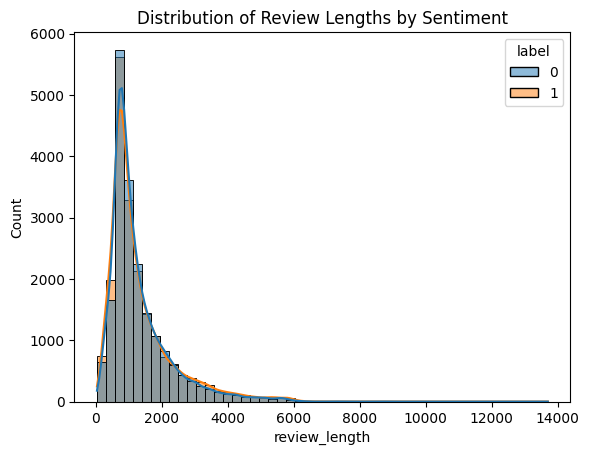

In [7]:
df['review_length'] = df['text'].apply(len)
df['review_length'].describe()
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=df, x='review_length', hue='label', bins=50, kde=True)
plt.title("Distribution of Review Lengths by Sentiment")
plt.show()


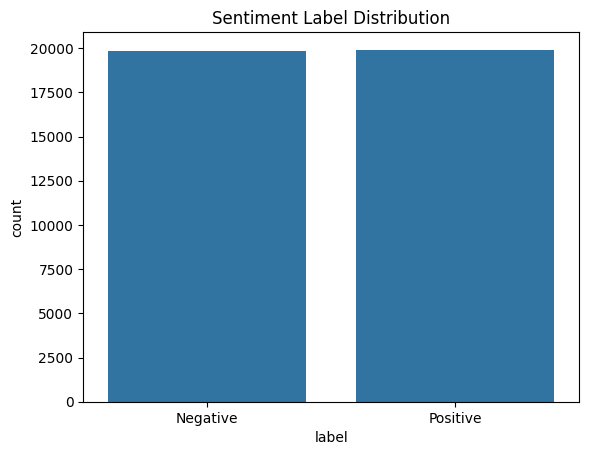

In [8]:
sns.countplot(x='label', data=df)
plt.title("Sentiment Label Distribution")
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()


Data Pre-processing


In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def remove_stopwords(text):
    words = re.sub(r'[^a-zA-Z\s]', '', text).lower().split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

df['text'] = df['text'].apply(remove_stopwords)
df.head()

,text,label
0,grew b watching loving thunderbirds mates scho...,0
1,put movie dvd player sat coke chips expectatio...,0
2,people know particular time past like feel nee...,0
3,even though great interest biblical movies bor...,0
4,im die hard dads army fan nothing ever change ...,1


In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [5]:
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

texts = df['text'].tolist()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens.")

padded_sequences = pad_sequences(sequences, padding='post')



Found 155305 unique tokens.


In [6]:
reverse_word_index = {v: k for k, v in word_index.items()}
lemmatized_texts = []

for sequence in sequences:
    tokens = [reverse_word_index.get(i, "") for i in sequence]
    lemmatized = lemmatize_tokens(tokens)
    lemmatized_texts.append(' '.join(lemmatized))

df['review_keras_lemmatized'] = lemmatized_texts


Feature Extraction

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_tfidf = TfidfVectorizer()
X_tfidf = vectorizer_tfidf.fit_transform(lemmatized_texts)

print("TF-IDF Feature Shape:", X_tfidf.shape)


TF-IDF Feature Shape: (40000, 145027)


In [15]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_bow = CountVectorizer()
X_bow = vectorizer_bow.fit_transform(lemmatized_texts)

print("BoW Feature Shape:", X_bow.shape)


BoW Feature Shape: (39723, 145027)


In [16]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_onehot = CountVectorizer(binary=True)
X_onehot = vectorizer_onehot.fit_transform(lemmatized_texts)

print("One-Hot Encoded Feature Shape:", X_onehot.shape)

One-Hot Encoded Feature Shape: (39723, 145027)


Model Selection

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import numpy as np

y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

print("\nLogistic Regression:")
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))


Logistic Regression:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      3966
           1       0.89      0.90      0.89      4034

    accuracy                           0.89      8000
   macro avg       0.89      0.89      0.89      8000
weighted avg       0.89      0.89      0.89      8000

Accuracy: 0.89275


In [18]:
print("\nBernoulli Naive Bayes:")
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
y_pred_bnb = bnb.predict(X_test)
print(classification_report(y_test, y_pred_bnb))
print("Accuracy:", accuracy_score(y_test, y_pred_bnb))


Bernoulli Naive Bayes:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      3991
           1       0.87      0.82      0.85      3954

    accuracy                           0.85      7945
   macro avg       0.85      0.85      0.85      7945
weighted avg       0.85      0.85      0.85      7945

Accuracy: 0.8504719949653871


In [19]:
print("\nRandom Forest:")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))


Random Forest:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      3991
           1       0.84      0.84      0.84      3954

    accuracy                           0.84      7945
   macro avg       0.84      0.84      0.84      7945
weighted avg       0.84      0.84      0.84      7945

Accuracy: 0.8397734424166142
